In [96]:
from astropy import units as u
from astropy.coordinates import Angle
from zenith_to_latlon_error import get_latlon
from multilateration import multilateration, angular_dist
import time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [97]:
import datetime

@dataclass
class StarInfo:
    ra: Angle
    dec: Angle 
    alt: Angle
    time: Tuple[int]

    def zd(self): 
        return Angle('90d') - self.alt

    def latlon(self):
        return get_latlon(*self.time, self.ra, self.dec)

    def add_time_delta(self, delta: datetime.timedelta):
        dt = datetime.datetime(*self.time)
        dt += delta
        self.time = (dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)


In [98]:
@dataclass
class MultilaterationResult:
    elapsed_time: float
    lat: Angle
    lon: Angle
    alt_bias: Angle
    err_angular: Angle
    err_nm: float

    def __str__(self):
        out = ""
        out += f"Elapsed: {self.elapsed_time}s\n"
        out += f"Latitude: {self.lat.to_string(unit=u.degree)}\n"
        out += f"Longitude: {self.lon.to_string(unit=u.degree)}\n"
        out += f"Alt. Bias: {self.alt_bias.to_string(unit=u.degree)}\n"
        out += f"Err. Angular Separation: {self.err_angular.to_string(unit=u.degree)} \n"
        out += f"Err. in NM: {self.err_nm}\n"
        return out

In [99]:
from typing import List


def run_multilateration(actual_latitude: Angle, actual_longitude: Angle, stardata: List[StarInfo]) -> MultilaterationResult:
    # radian vs radians below is because lat / lon coordinates are Skyfield Angles
    # whereas the zd coordiantes are astropy angles
    points = [([l.radians for l in p.latlon()], p.zd().radian) for p in stardata]

    before = time.time()
    result_lat_rads, result_lon_rads, result_alt_bias_rads = multilateration(points).x
    elapsed = time.time() - before

    result_lat = Angle(result_lat_rads, u.radian)
    result_lon = Angle(result_lon_rads, u.radian)
    result_alt_bias = Angle(result_alt_bias_rads, u.radian)

    error_angular = angular_dist((result_lat.radian, result_lon.radian), (actual_latitude.radian, actual_longitude.radian))
    error_angular = Angle(error_angular, u.radian)

    error_nm = error_angular.arcminute

    return MultilaterationResult(elapsed, result_lat, result_lon, result_alt_bias, error_angular, error_nm)

In [100]:
# Params
alt_bias = Angle('3d')

# Actual
actual_latitude = Angle('+37d 10m 44.76s')
actual_longitude = Angle('-80d 21m 5.41s')

measure_time = (2022, 10, 24, 5, 25, 51)

# Betelgeuse
betelgeuse_ra = Angle('5h 55m 11.10s')
betelgeuse_dec = Angle('+7d 24m 30.6s')
betelgeuse_alt = Angle('+31d 48m 45.1s')

# Algenib
algenib_ra = Angle('0h 13m 15.31s')
algenib_dec = Angle('+15d 11m 10.1s')
algenib_alt = Angle('+55d 32m 08.6s')

# Schedar
schedar_ra = Angle('0h 40m 32.73s')
schedar_dec = Angle('+56d 32m 24.7s')
schedar_alt = Angle('+65d 07m 21.8s')

# Summarized data
stardata = [ 
    StarInfo(betelgeuse_ra, betelgeuse_dec, betelgeuse_alt, measure_time),
    StarInfo(algenib_ra, algenib_dec, algenib_alt, measure_time),
    StarInfo(schedar_ra, schedar_dec, schedar_alt, measure_time),
]

# Monte Carlo Simulation

Error Budget
|  Error Source  |   Bias   |    Std. Dev    |
|----------------|----------|----------------|
|    Altitude    |   1.5d   |      0.2      |
|   Plate Solve  |    0d    |    11arcsec    |
|      Time      |    4s    |     0.001s     |

In [115]:
import copy

def add_noise(altitude_distr, ps_distr, time_distr, data: List[StarInfo]):
    altitude_bias, altitude_sd = altitude_distr
    ps_bias, ps_sd = ps_distr
    time_bias, time_sd = time_distr

    newdata = copy.deepcopy(data)
    for star in newdata:
        star.alt += Angle(np.median(np.random.normal(altitude_bias, altitude_sd, (30,))), unit=u.degree)
        star.ra += Angle(np.random.normal(ps_bias, ps_sd), unit=u.degree)
        star.dec += Angle(np.random.normal(ps_bias, ps_sd), unit=u.degree)
        star.add_time_delta(datetime.timedelta(seconds=np.random.normal(time_bias, time_sd)))

    return newdata


def monte_carlo(altitude_distr, ps_distr, time_distr, n, title="Monte Carlo Simulation"):
    n = 500
    errors = np.empty((n,))

    for i in tqdm(range(len(errors))):
        errors[i] = run_multilateration(
            actual_latitude, 
            actual_longitude, 
            add_noise(altitude_distr, ps_distr, time_distr, stardata)
        ).err_nm
    
    plt.figure()
    plt.hist(errors, bins=40)
    plt.title(title)
    plt.xlabel("Error, NM")
    plt.ylabel("Frequency")


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


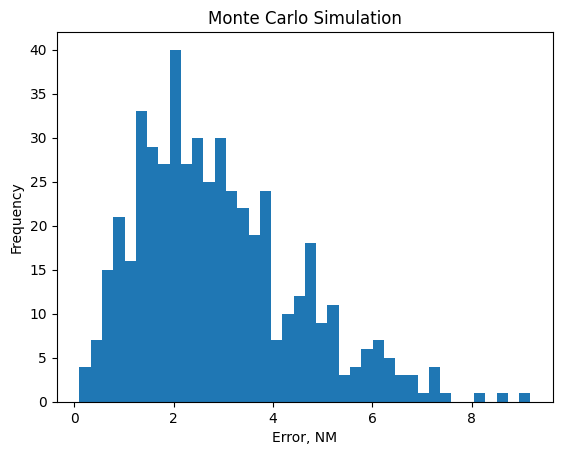

In [117]:
monte_carlo(
    altitude_distr=(1.5, 0.2),  # Degrees
    ps_distr=(0, 11 / 3600),  # Degrees (from arcsec)
    time_distr=(4, 0.001),  # Sec
    n=500,
)

100%|██████████| 500/500 [00:20<00:00, 24.24it/s]


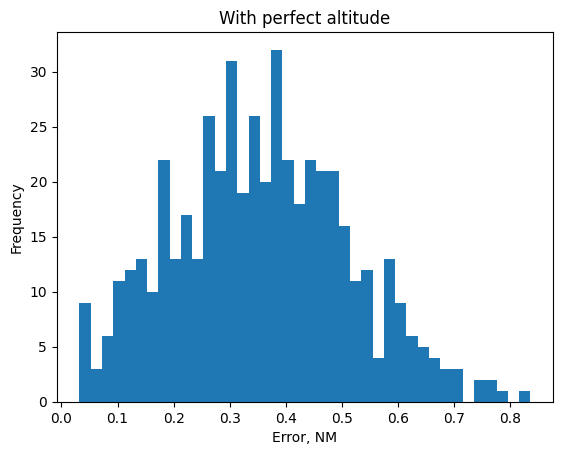

In [118]:
monte_carlo(
    altitude_distr=(0,0),  # Degrees
    ps_distr=(0, 11 / 3600),  # Degrees (from arcsec)
    time_distr=(4, 0.001),  # Sec
    n=500,
    title="With perfect altitude"
)

100%|██████████| 500/500 [00:20<00:00, 24.18it/s]


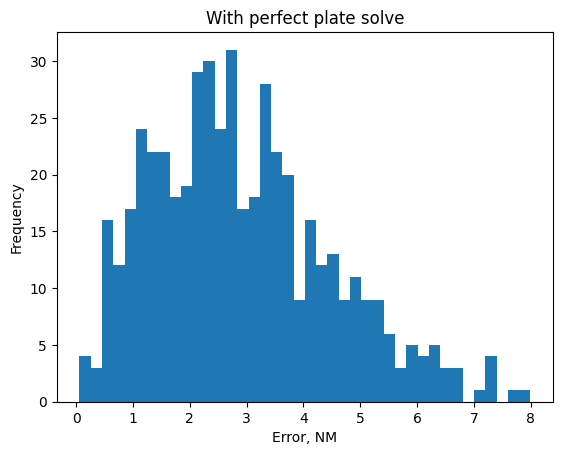

In [119]:
monte_carlo(
    altitude_distr=(1.5, 0.2),  # Degrees
    ps_distr=(0, 0),  # Degrees (from arcsec)
    time_distr=(4, 0.001),  # Sec
    n=500,
    title="With perfect plate solve"
)

100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


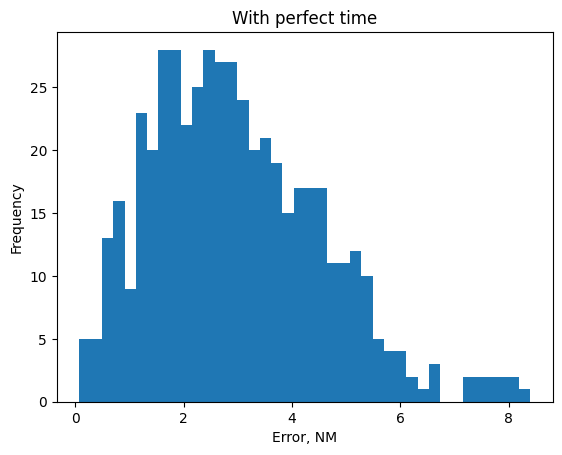

In [120]:
monte_carlo(
    altitude_distr=(1.5, 0.2),  # Degrees
    ps_distr=(0, 11 / 3600),  # Degrees (from arcsec)
    time_distr=(0,0),  # Sec
    n=500,
    title="With perfect time"
)